# <span style="color:blue">EVAC Workshop 4: Genetic Programming</span>

**Module leader**

Simon O'Keefe: simon.okeefe@york.ac.uk

**Graduate Teaching Assistants**

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

## <span style="color:#0073e6">Prerequisites</span>

Before participating in this practical make sure that you have watched the pre-workshop materials:
- Lecture 4
- Code walkthrough 4

# Colab Packages Install

## Learning Objectives

- Learn how to program a standard GP in DEAP
- Learn what kinds of problems GP can be applied to
- Learn the basics of loosely-typed GP in DEAP

# <span style="color:blue">Exercise: Symbolic Regression with GP</span>

To learn genetic programming (GP) we will continue the regression theme and look at a regression problem that needs non-linear expressions. Symbolic regression is about learning equations. Whereas with a GA you need to specify what you think the best model is (e.g. polynomials etc.), with GP the algorithm can decide. This is useful when dealing with more complex data. Here, the data is simply generated by a known function against which we can evaluate.

# <span style="color:blue">Your Task</span>

Using what you know from the lecture and walkthrough: **Your task is to code a GP algorithm to solve a regression problem where the solution is the equation:**

$f(x)$ = $x^{4}$ - $x^{3}$ - $x^{2}$ - $x$

In [12]:
from deap import base, creator, gp, tools

SET_ARITY = 1
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
pset = gp.PrimitiveSet("main", SET_ARITY)
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)


def f(x):
    return (x**4) - (x**3) - (x**2) - x


def evalSymbReg(individual, points):
    func = toolbox.compile(expr=individual)
    fitness = 0
    for point in points:
        try:
            fitness += abs(func(point) - f(point))
        except:  # noqa: E722
            # Since we have powers, things like trying to raise to a negative power or overflows can happen. Kill off individuals that have these issues.
            return (100000000,)
    return (fitness,)

Once you have written your evaluation function, you can then set up a toolbox and register your evaluation function. When you do this, you can specify the range of values over which to assess the individual. Your fitness function should aim to evaluate the error between the individual’s expression and this actual data-generating function.

The code below would register our evaluation function 'evalSymbReg' and pass in argument 'points' which contains values from -10 to 10 every 0.1. Thus we register the range of values of x on which we want to evaluate.

In [13]:
toolbox.register("evaluate", evalSymbReg, points=[x / 10.0 for x in range(-100, 100)])

In [14]:
import operator
import random

pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.pow, 2)
pset.addEphemeralConstant("randInt", lambda: random.randint(0, 5))
pset.renameArguments(ARG0="x")

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
toolbox.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8)
)

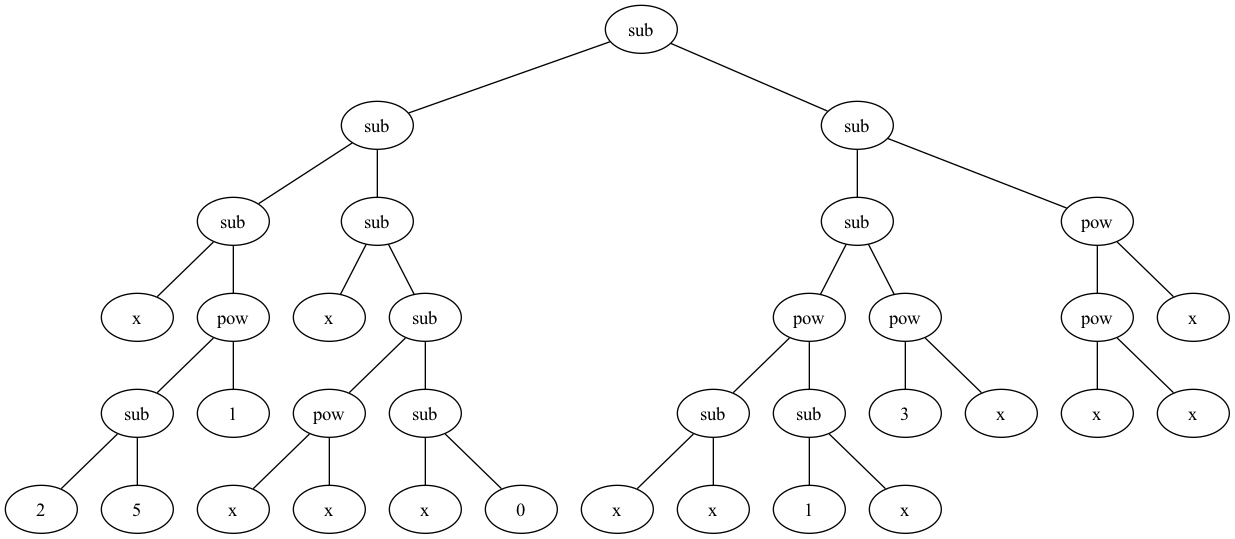

In [15]:
import pygraphviz as pgv
from IPython.display import Image

ind = toolbox.individual()

nodes, edges, labels = gp.graph(ind)
tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
Image(treePlot)

In [16]:
print(toolbox.evaluate(ind))

ZeroDivisionError: 0.0 cannot be raised to a negative power

Whereas in the walkthrough I showed you how to fit to data, here, we are doing the same thing, but we are generating the data on-the-fly using the data-generating function that we have decided to use. We can change that function to be anything we want, and even add randomness to it if we like. We pass the individual to the evaluation function, just as we have always done previously. But we also pass the inputs that we want to evaluate. I choose to pass in a big range of points that are systematically generated, but you could chose to pass random x values if you like. This data-generating function that we are fitting to can be changed to anything you like (see later task).

In [ ]:
import numpy

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

In [ ]:
from deap import algorithms

pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(
    pop,
    toolbox,
    cxpb=0.5,
    mutpb=0.1,
    ngen=150,
    stats=mstats,
    halloffame=hof,
    verbose=True,
)

**Once you have implemented a solution, be sure to output statistics, plot trees, and take a look at the final solution. Also, explore parameters and assumptions of the algorithm, etc.**
**Also be sure to run your code multiple times to see the impact of random starting conditions etc.**

In [ ]:
best_ind = tools.selBest(pop, 1)[0]
print(best_ind)
print(best_ind.fitness)
nodes, edges, labels = gp.graph(best_ind)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

treePlot = tree.draw(format="png", prog="dot")
Image(treePlot)

Start with a more complex primitive set and experiment with changes to it. How much can you slim it down, and what impact does it have?

You will notice that the final solution performs well but is not very concise. This is common in GP and is called 'bloating'. Why do you think bloating happens? This is a topic covered in the next lecture and workshop.

# <span style="color:blue">Additional Task 1</span>

Add a static depth limit to your mutation and mating operators. Set the limit to 8. Remember that this limit is a limit on the overall depth of an individual. Re-run and look at the final tree.

## Done above, solution becomes way too complex without it

# <span style="color:blue">Additional Task 2</span>

Let's change your evaluation function to something more difficult. For example, you could use something from the DEAP benchmarks such as deap.benchmarks.gp.ripple (see library reference). The ripple function takes in two arguments and is defined as:

$f(x)$ = ($x_{1} - 3$) - ($x_{2} - 3$) + 2sin(($x_{1} - 4$)($x_2 - 4$))

With range x $∈[-5,5$]^2

# <span style="color:blue">Additional Task 3</span>

You can actually implement multiple types of mutation functions in GP. Because of the tree structure, there are many different ways that you can change individuals.

Go to the DEAP library reference and read about the different gp mutation operators such as gp.mutShrink(), gp.mutNodeReplacement(), go.mutInsert(), and gp.mutEphemeral().

Implement gp.mutShrink() in to you code in addition to the current mutation operator.